In [1]:
import os
import time
import json
import random
import numpy as np
import matplotlib.pyplot as plt
import itertools
from scipy.spatial import ConvexHull
from numpy.linalg import svd, det

import pinocchio as pin
from pinocchio import SE3, buildGeomFromUrdf
from pinocchio.robot_wrapper import RobotWrapper
from pinocchio.visualize import MeshcatVisualizer
from pinocchio import CollisionPair

import meshcat
import meshcat.geometry as g
from meshcat.transformations import scale_matrix
from itertools import combinations

from hppfcl import CollisionObject
import pyvista as pv
pv.set_jupyter_backend("trame")

import casadi as ca
import pinocchio.casadi as cpin
import pycapacity.robot as pycap
import numpy as np
from hppfcl import Box
from collections import namedtuple

In [2]:
# URDF paths
# jvrc1_urdf = "/home/lmoussafir/workspace/src/catkin_data_ws/src/mc_rtc_data/jvrc_description/urdf/jvrc1.urdf"
jvrc1_urdf ="/home/lmoussafir/Documents/SchaefflerEnv/Tests/jvrc_description-master/urdf/jvrc1.urdf"
palette_urdf = "/home/lmoussafir/workspace/install/share/mc_rtc/palette_box/urdf/palette_box.urdf"
feeder_urdf = "/home/lmoussafir/workspace/install/share/mc_rtc/part_feeder/urdf/part_feeder.urdf"


ENABLE_RIGHT_ARM = True
ENABLE_LEFT_ARM = False 
include_torso_pitch = False  # ajoute le DOF de pitch du torse
include_torso_roll = False  # ajoute le DOF de roll du torse
# Transformation of objects in the world frame
T_palette = SE3.Identity()
T_palette.translation = np.array([0.6, -0.3, -0.3])
T_feeder = SE3.Identity()
T_feeder.translation = np.array([0.6, 0.3, -0.5])
# List of external collision objects (palette + feeder)
external_object_names = [
    "part_feeder_convex_0",
    "part_feeder_convex_1",
    "part_feeder_convex_2",
    "part_feeder_convex_3",
    "part_feeder_convex_4",
    "base_link_0",
    "base_link_1",
    "base_link_2",
    "base_link_3",
    "base_link_4"
]

# List of robot convex objects for collision checks
robot_convex_name = [
    'L_ELBOW_P_S_0', 'L_ELBOW_Y_S_0', 'L_SHOULDER_P_S_0', 'L_SHOULDER_Y_S_0',
    'L_WRIST_Y_S_0', 'NECK_P_S_0', 'NECK_Y_S_0', 'R_ELBOW_P_S_0',
    'R_ELBOW_Y_S_0', 'R_SHOULDER_P_S_0', 'R_SHOULDER_Y_S_0', 'R_WRIST_Y_S_0',
    'WAIST_R_S_0', 'WAIST_Y_S_0','right_arm_m1_0',
     'right_arm_shoulder_l1_0',
     'right_arm_m2_0',
     'right_arm_shoulder_l2_0',
     'right_arm_m3_0',
     'right_arm_elbow_l1_0',
     'right_arm_m4_0',
     'right_arm_elbow_l2_0',
     'right_arm_m5_0',
     'right_arm_wrist_l1_0',
     'right_arm_m6_0',
     'right_arm_wrist_l2_0',
     'right_arm_wrist_l3_0',
     'right_arm_eef_0'
]

# Effectors
frame_name_right = "R_WRIST_Y"
frame_name_left = "L_WRIST_Y"

# Joint names per arm
joint_names_right = [
    "R_SHOULDER_P", "R_SHOULDER_R", "R_SHOULDER_Y",
    "R_ELBOW_P", "R_ELBOW_Y", "R_WRIST_R", "R_WRIST_Y"
]
joint_names_left = [
    "L_SHOULDER_P", "L_SHOULDER_R", "L_SHOULDER_Y",
    "L_ELBOW_P", "L_ELBOW_Y", "L_WRIST_R", "L_WRIST_Y"
]


In [3]:
# Load robot model
jvrc1 = RobotWrapper.BuildFromURDF(jvrc1_urdf)
q0 = pin.neutral(jvrc1.model)

# Load external objects
palette = RobotWrapper.BuildFromURDF(palette_urdf)
feeder = RobotWrapper.BuildFromURDF(feeder_urdf)

# Merge external objects into robot collision/visual model
for obj in palette.collision_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_palette * obj.placement
    jvrc1.collision_model.addGeometryObject(new_obj)
for obj in feeder.collision_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_feeder * obj.placement
    jvrc1.collision_model.addGeometryObject(new_obj)
for obj in palette.visual_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_palette * obj.placement
    jvrc1.visual_model.addGeometryObject(new_obj)
for obj in feeder.visual_model.geometryObjects:
    new_obj = obj.copy()
    new_obj.placement = T_feeder * obj.placement
    jvrc1.visual_model.addGeometryObject(new_obj)

In [4]:
viz = MeshcatVisualizer(jvrc1.model, jvrc1.collision_model, jvrc1.visual_model)
viz.initViewer(loadModel=True)
viz.display(q0)

# Define pairs to add for self-collision filtering
def find_geom_index_by_name(cmodel, name, allow_partial_suffix=False):
    for i, obj in enumerate(cmodel.geometryObjects):
        if obj.name == name:
            return i
    if allow_partial_suffix:
        for i, obj in enumerate(cmodel.geometryObjects):
            if obj.name.startswith(name):
                print(f"[INFO] Partial match: '{name}' matched '{obj.name}'")
                return i
    raise ValueError(f"[ERROR] Object '{name}' not found in collision_model")

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7002/static/


In [5]:
# Define self-collision pairs (modifiable si nécessaire)
pairs_to_add = [
    ("NECK_P_S_0", "WAIST_Y_S_0"), ("NECK_P_S_0", "WAIST_R_S_0"),
    ("NECK_P_S_0", "R_SHOULDER_P_S_0"), ("NECK_P_S_0", "R_SHOULDER_Y_S_0"),
    ("NECK_P_S_0", "R_ELBOW_P_S_0"), ("NECK_P_S_0", "R_ELBOW_Y_S_0"),
    ("NECK_P_S_0", "R_WRIST_Y_S_0"),
    ("NECK_Y_S_0", "R_SHOULDER_P_S_0"), ("NECK_Y_S_0", "R_SHOULDER_Y_S_0"),
    ("NECK_Y_S_0", "R_ELBOW_P_S_0"), ("NECK_Y_S_0", "R_ELBOW_Y_S_0"), ("NECK_Y_S_0", "R_WRIST_Y_S_0"),
    ("WAIST_Y_S_0", "R_SHOULDER_P_S_0"), ("WAIST_Y_S_0", "R_SHOULDER_Y_S_0"),
    ("WAIST_Y_S_0", "R_ELBOW_P_S_0"), ("WAIST_Y_S_0", "R_ELBOW_Y_S_0"), ("WAIST_Y_S_0", "R_WRIST_Y_S_0"),
    ("WAIST_R_S_0", "R_SHOULDER_Y_S_0"), ("WAIST_R_S_0", "R_ELBOW_P_S_0"), ("WAIST_R_S_0", "R_ELBOW_Y_S_0"), ("WAIST_R_S_0", "R_WRIST_Y_S_0"),
    ("R_SHOULDER_P_S_0", "R_ELBOW_P_S_0"), ("R_SHOULDER_P_S_0", "R_ELBOW_Y_S_0"), ("R_SHOULDER_P_S_0", "R_WRIST_Y_S_0"),
    ("R_SHOULDER_Y_S_0", "R_ELBOW_Y_S_0"), ("R_SHOULDER_Y_S_0", "R_WRIST_Y_S_0"),
    ("R_ELBOW_P_S_0", "R_WRIST_Y_S_0"),
    ("NECK_P_S_0", "L_SHOULDER_P_S_0"), ("NECK_P_S_0", "L_SHOULDER_Y_S_0"),
    ("NECK_P_S_0", "L_ELBOW_P_S_0"), ("NECK_P_S_0", "L_ELBOW_Y_S_0"), ("NECK_P_S_0", "L_WRIST_Y_S_0"),
    ("NECK_Y_S_0", "L_SHOULDER_P_S_0"), ("NECK_Y_S_0", "L_SHOULDER_Y_S_0"),
    ("NECK_Y_S_0", "L_ELBOW_P_S_0"), ("NECK_Y_S_0", "L_ELBOW_Y_S_0"), ("NECK_Y_S_0", "L_WRIST_Y_S_0"),
    ("WAIST_Y_S_0", "L_SHOULDER_P_S_0"), ("WAIST_Y_S_0", "L_SHOULDER_Y_S_0"),
    ("WAIST_Y_S_0", "L_ELBOW_P_S_0"), ("WAIST_Y_S_0", "L_ELBOW_Y_S_0"), ("WAIST_Y_S_0", "L_WRIST_Y_S_0"),
    ("WAIST_R_S_0", "L_SHOULDER_Y_S_0"), ("WAIST_R_S_0", "L_ELBOW_P_S_0"), ("WAIST_R_S_0", "L_ELBOW_Y_S_0"), ("WAIST_R_S_0", "L_WRIST_Y_S_0"),
    ("L_SHOULDER_P_S_0", "L_ELBOW_P_S_0"), ("L_SHOULDER_P_S_0", "L_ELBOW_Y_S_0"), ("L_SHOULDER_P_S_0", "L_WRIST_Y_S_0"),
    ("L_SHOULDER_Y_S_0", "L_ELBOW_Y_S_0"), ("L_SHOULDER_Y_S_0", "L_WRIST_Y_S_0"), ("L_ELBOW_P_S_0", "L_WRIST_Y_S_0")
]
pairs_to_add += [
    ("right_arm_m1_0", "right_arm_m2_0"),
    ("right_arm_m1_0", "right_arm_shoulder_l2_0"),
    ("right_arm_m1_0", "right_arm_m3_0"),
    ("right_arm_m1_0", "right_arm_elbow_l1_0"),
    ("right_arm_m1_0", "right_arm_m4_0"),
    ("right_arm_m1_0", "right_arm_elbow_l2_0"),
    ("right_arm_m1_0", "right_arm_m5_0"),
    ("right_arm_m1_0", "right_arm_wrist_l1_0"),
    ("right_arm_m1_0", "right_arm_m6_0"),
    ("right_arm_m1_0", "right_arm_wrist_l2_0"),
    ("right_arm_m1_0", "right_arm_m7_0"),
    ("right_arm_m1_0", "right_arm_wrist_l3_0"),

    ("right_arm_shoulder_l1_0", "right_arm_m3_0"),
    ("right_arm_shoulder_l1_0", "right_arm_elbow_l1_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m4_0"),
    ("right_arm_shoulder_l1_0", "right_arm_elbow_l2_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m5_0"),
    ("right_arm_shoulder_l1_0", "right_arm_wrist_l1_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m6_0"),
    ("right_arm_shoulder_l1_0", "right_arm_wrist_l2_0"),
    ("right_arm_shoulder_l1_0", "right_arm_m7_0"),
    ("right_arm_shoulder_l1_0", "right_arm_wrist_l3_0"),

    ("right_arm_m2_0", "right_arm_m3_0"),
    ("right_arm_m2_0", "right_arm_elbow_l1_0"),
    ("right_arm_m2_0", "right_arm_m4_0"),
    ("right_arm_m2_0", "right_arm_elbow_l2_0"),
    ("right_arm_m2_0", "right_arm_m5_0"),
    ("right_arm_m2_0", "right_arm_wrist_l1_0"),
    ("right_arm_m2_0", "right_arm_m6_0"),
    ("right_arm_m2_0", "right_arm_wrist_l2_0"),
    ("right_arm_m2_0", "right_arm_m7_0"),
    ("right_arm_m2_0", "right_arm_wrist_l3_0"),


    ("right_arm_shoulder_l2_0", "right_arm_m4_0"),
    ("right_arm_shoulder_l2_0", "right_arm_elbow_l2_0"),
    ("right_arm_shoulder_l2_0", "right_arm_m5_0"),
    ("right_arm_shoulder_l2_0", "right_arm_wrist_l1_0"),
    ("right_arm_shoulder_l2_0", "right_arm_m6_0"),
    ("right_arm_shoulder_l2_0", "right_arm_wrist_l2_0"),
    ("right_arm_shoulder_l2_0", "right_arm_m7_0"),
    ("right_arm_shoulder_l2_0", "right_arm_wrist_l3_0"),

    ("right_arm_m3_0", "right_arm_m4_0"),
    ("right_arm_m3_0", "right_arm_elbow_l2_0"),
    ("right_arm_m3_0", "right_arm_m5_0"),
    ("right_arm_m3_0", "right_arm_wrist_l1_0"),
    ("right_arm_m3_0", "right_arm_m6_0"),
    ("right_arm_m3_0", "right_arm_wrist_l2_0"),
    ("right_arm_m3_0", "right_arm_m7_0"),
    ("right_arm_m3_0", "right_arm_wrist_l3_0"),

    ("right_arm_elbow_l1_0", "right_arm_m5_0"),
    ("right_arm_elbow_l1_0", "right_arm_wrist_l1_0"),
    ("right_arm_elbow_l1_0", "right_arm_m6_0"),
    ("right_arm_elbow_l1_0", "right_arm_wrist_l2_0"),
    ("right_arm_elbow_l1_0", "right_arm_m7_0"),
    ("right_arm_elbow_l1_0", "right_arm_wrist_l3_0"),

    ("right_arm_m4_0", "right_arm_m5_0"),
    ("right_arm_m4_0", "right_arm_wrist_l1_0"),
    ("right_arm_m4_0", "right_arm_m6_0"),
    ("right_arm_m4_0", "right_arm_wrist_l2_0"),
    ("right_arm_m4_0", "right_arm_m7_0"),
    ("right_arm_m4_0", "right_arm_wrist_l3_0"),


    ("right_arm_elbow_l2_0", "right_arm_m6_0"),
    ("right_arm_elbow_l2_0", "right_arm_wrist_l2_0"),
    ("right_arm_elbow_l2_0", "right_arm_m7_0"),
    ("right_arm_elbow_l2_0", "right_arm_wrist_l3_0"),

    ("right_arm_m5_0", "right_arm_m6_0"),
    ("right_arm_m5_0", "right_arm_wrist_l2_0"),
    ("right_arm_m5_0", "right_arm_m7_0"),
    ("right_arm_m5_0", "right_arm_wrist_l3_0"),


    ("right_arm_wrist_l1_0", "right_arm_m7_0"),
    ("right_arm_wrist_l1_0", "right_arm_wrist_l3_0"),

    ("right_arm_m6_0", "right_arm_m7_0"),
    ("right_arm_m6_0", "right_arm_wrist_l3_0"),


    ("right_arm_wrist_l2_0", "right_arm_eef_0"),

    ("NECK_Y_S_0", "right_arm_m1_0"),
    ("NECK_Y_S_0", "right_arm_shoulder_l1_0"),
    ("NECK_Y_S_0", "right_arm_m2_0"),
    ("NECK_Y_S_0", "right_arm_shoulder_l2_0"),
    ("NECK_Y_S_0", "right_arm_m3_0"),
    ("NECK_Y_S_0", "right_arm_elbow_l1_0"),
    ("NECK_Y_S_0", "right_arm_m4_0"),
    ("NECK_Y_S_0", "right_arm_elbow_l2_0"),
    ("NECK_Y_S_0", "right_arm_m5_0"),
    ("NECK_Y_S_0", "right_arm_wrist_l1_0"),
    ("NECK_Y_S_0", "right_arm_m6_0"),
    ("NECK_Y_S_0", "right_arm_wrist_l2_0"),
    ("NECK_Y_S_0", "right_arm_wrist_l3_0"),
    ("NECK_Y_S_0", "right_arm_eef_0"),

    ("NECK_P_S_0", "right_arm_m1_0"),
    ("NECK_P_S_0", "right_arm_shoulder_l1_0"),
    ("NECK_P_S_0", "right_arm_m2_0"),
    ("NECK_P_S_0", "right_arm_shoulder_l2_0"),
    ("NECK_P_S_0", "right_arm_m3_0"),
    ("NECK_P_S_0", "right_arm_elbow_l1_0"),
    ("NECK_P_S_0", "right_arm_m4_0"),
    ("NECK_P_S_0", "right_arm_elbow_l2_0"),
    ("NECK_P_S_0", "right_arm_m5_0"),
    ("NECK_P_S_0", "right_arm_wrist_l1_0"),
    ("NECK_P_S_0", "right_arm_m6_0"),
    ("NECK_P_S_0", "right_arm_wrist_l2_0"),
    ("NECK_P_S_0", "right_arm_wrist_l3_0"),
    ("NECK_P_S_0", "right_arm_eef_0"),

    ("WAIST_Y_S_0", "right_arm_m1_0"),
    ("WAIST_Y_S_0", "right_arm_shoulder_l1_0"),
    ("WAIST_Y_S_0", "right_arm_m2_0"),
    ("WAIST_Y_S_0", "right_arm_shoulder_l2_0"),
    ("WAIST_Y_S_0", "right_arm_m3_0"),
    ("WAIST_Y_S_0", "right_arm_elbow_l1_0"),
    ("WAIST_Y_S_0", "right_arm_m4_0"),
    ("WAIST_Y_S_0", "right_arm_elbow_l2_0"),
    ("WAIST_Y_S_0", "right_arm_m5_0"),
    ("WAIST_Y_S_0", "right_arm_wrist_l1_0"),
    ("WAIST_Y_S_0", "right_arm_m6_0"),
    ("WAIST_Y_S_0", "right_arm_wrist_l2_0"),
    ("WAIST_Y_S_0", "right_arm_wrist_l3_0"),
    ("WAIST_Y_S_0", "right_arm_eef_0"),

    ("WAIST_R_S_0", "right_arm_shoulder_l1_0"),
    ("WAIST_R_S_0", "right_arm_m2_0"),
    ("WAIST_R_S_0", "right_arm_shoulder_l2_0"),
    ("WAIST_R_S_0", "right_arm_m3_0"),
    ("WAIST_R_S_0", "right_arm_elbow_l1_0"),
    ("WAIST_R_S_0", "right_arm_m4_0"),
    ("WAIST_R_S_0", "right_arm_elbow_l2_0"),
    ("WAIST_R_S_0", "right_arm_m5_0"),
    ("WAIST_R_S_0", "right_arm_wrist_l1_0"),
    ("WAIST_R_S_0", "right_arm_m6_0"),
    ("WAIST_R_S_0", "right_arm_wrist_l2_0"),
    ("WAIST_R_S_0", "right_arm_wrist_l3_0"),
    ("WAIST_R_S_0", "right_arm_eef_0"),

]

# Add all specified internal pairs
for name1, name2 in pairs_to_add:
    try:
        idx1 = find_geom_index_by_name(jvrc1.collision_model, name1, allow_partial_suffix=True)
        idx2 = find_geom_index_by_name(jvrc1.collision_model, name2, allow_partial_suffix=True)
        jvrc1.collision_model.addCollisionPair(CollisionPair(idx1, idx2))
    except Exception as e:
        print(f"[WARN] Could not add pair ({name1}, {name2}): {e}")

# Add robot ↔ environment pairs
added_pairs = set()
for ext_name in external_object_names:
    try:
        idx_ext = find_geom_index_by_name(jvrc1.collision_model, ext_name, allow_partial_suffix=True)
        for rob_name in robot_convex_name:
            try:
                idx_rob = find_geom_index_by_name(jvrc1.collision_model, rob_name, allow_partial_suffix=True)
                pair = CollisionPair(idx_ext, idx_rob)
                if (pair.first, pair.second) not in added_pairs and (pair.second, pair.first) not in added_pairs:
                    jvrc1.collision_model.addCollisionPair(pair)
                    added_pairs.add((pair.first, pair.second))
            except Exception as e_rob:
                print(f"[WARN] Robot object error '{rob_name}': {e_rob}")
    except Exception as e_ext:
        print(f"[WARN] External object error '{ext_name}': {e_ext}")

# Build filtered models (left/right arm collision models)
def is_pair_for_side(pair, geom_model, exclude_prefixes):
    g1 = geom_model.geometryObjects[pair.first].name
    g2 = geom_model.geometryObjects[pair.second].name
    return all(not g.startswith(prefix) for g in [g1, g2] for prefix in exclude_prefixes)

exclude_for_right = ["L_"]
exclude_for_left = ["R_","right_"]

collision_model_right = pin.GeometryModel()
collision_model_left = pin.GeometryModel()

for obj in jvrc1.collision_model.geometryObjects:
    collision_model_right.addGeometryObject(obj)
    collision_model_left.addGeometryObject(obj)

for pair in jvrc1.collision_model.collisionPairs:
    if is_pair_for_side(pair, jvrc1.collision_model, exclude_for_right):
        collision_model_right.addCollisionPair(pair)
    if is_pair_for_side(pair, jvrc1.collision_model, exclude_for_left):
        collision_model_left.addCollisionPair(pair)

collision_data_right = pin.GeometryData(collision_model_right)
collision_data_left = pin.GeometryData(collision_model_left)

# Get joint IDs
joint_ids_right = [jvrc1.model.getJointId(name) for name in joint_names_right]
joint_ids_left = [jvrc1.model.getJointId(name) for name in joint_names_left]
# print("Right arm joint IDs:", joint_ids_right)
# print("Left arm joint IDs:", joint_ids_left)

[WARN] Could not add pair (NECK_P_S_0, R_SHOULDER_P_S_0): [ERROR] Object 'R_SHOULDER_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_SHOULDER_Y_S_0): [ERROR] Object 'R_SHOULDER_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_ELBOW_P_S_0): [ERROR] Object 'R_ELBOW_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_ELBOW_Y_S_0): [ERROR] Object 'R_ELBOW_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_P_S_0, R_WRIST_Y_S_0): [ERROR] Object 'R_WRIST_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_SHOULDER_P_S_0): [ERROR] Object 'R_SHOULDER_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_SHOULDER_Y_S_0): [ERROR] Object 'R_SHOULDER_Y_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_ELBOW_P_S_0): [ERROR] Object 'R_ELBOW_P_S_0' not found in collision_model
[WARN] Could not add pair (NECK_Y_S_0, R_ELBOW_Y_S_0): [

In [6]:
def list_collision_pairs(model, label):
    print(f"\n[INFO] Collision pairs in {label}:")
    for pair in model.collisionPairs:
        g1 = model.geometryObjects[pair.first].name
        g2 = model.geometryObjects[pair.second].name
        print(f"  - {g1} ↔ {g2}")

list_collision_pairs(jvrc1.collision_model, "full model")
list_collision_pairs(collision_model_right, "right arm")
list_collision_pairs(collision_model_left, "left arm")



[INFO] Collision pairs in full model:
  - NECK_P_S_0 ↔ WAIST_Y_S_0
  - NECK_P_S_0 ↔ WAIST_R_S_0
  - NECK_P_S_0 ↔ L_SHOULDER_P_S_0
  - NECK_P_S_0 ↔ L_SHOULDER_Y_S_0
  - NECK_P_S_0 ↔ L_ELBOW_P_S_0
  - NECK_P_S_0 ↔ L_ELBOW_Y_S_0
  - NECK_P_S_0 ↔ L_WRIST_Y_S_0
  - NECK_Y_S_0 ↔ L_SHOULDER_P_S_0
  - NECK_Y_S_0 ↔ L_SHOULDER_Y_S_0
  - NECK_Y_S_0 ↔ L_ELBOW_P_S_0
  - NECK_Y_S_0 ↔ L_ELBOW_Y_S_0
  - NECK_Y_S_0 ↔ L_WRIST_Y_S_0
  - WAIST_Y_S_0 ↔ L_SHOULDER_P_S_0
  - WAIST_Y_S_0 ↔ L_SHOULDER_Y_S_0
  - WAIST_Y_S_0 ↔ L_ELBOW_P_S_0
  - WAIST_Y_S_0 ↔ L_ELBOW_Y_S_0
  - WAIST_Y_S_0 ↔ L_WRIST_Y_S_0
  - WAIST_R_S_0 ↔ L_SHOULDER_Y_S_0
  - WAIST_R_S_0 ↔ L_ELBOW_P_S_0
  - WAIST_R_S_0 ↔ L_ELBOW_Y_S_0
  - WAIST_R_S_0 ↔ L_WRIST_Y_S_0
  - L_SHOULDER_P_S_0 ↔ L_ELBOW_P_S_0
  - L_SHOULDER_P_S_0 ↔ L_ELBOW_Y_S_0
  - L_SHOULDER_P_S_0 ↔ L_WRIST_Y_S_0
  - L_SHOULDER_Y_S_0 ↔ L_ELBOW_Y_S_0
  - L_SHOULDER_Y_S_0 ↔ L_WRIST_Y_S_0
  - L_ELBOW_P_S_0 ↔ L_WRIST_Y_S_0
  - right_arm_m1_0 ↔ right_arm_m2_0
  - right_arm_m1_0 ↔ right_ar

In [7]:
def display_ellipsoids_in_meshcat(viewer, terms, q=None, name_prefix="ellipsoids/"):
    """
    Affiche une liste d'ellipsoïdes dans Meshcat à partir de leur fonction de centre et dimensions.
    
    :param viewer: viz.viewer
    :param terms: liste de EllipsoidTerm (center_fn, axes_lengths, name)
    :param q: configuration à évaluer (np.ndarray), si None utilise q_start
    :param name_prefix: préfixe du nom dans le viewer
    """
    if q is None:
        q = pin.neutral(jvrc1.model)

    for term in terms:
        center = np.array(term.center_fn(q)).flatten()
        axes = term.axes_lengths

        ell = g.Ellipsoid(axes)
        viewer[name_prefix + term.name].set_object(
            ell, g.MeshLambertMaterial(opacity=0.3, color=0xff0000)
        )
        T = np.eye(4)
        T[:3, 3] = center
        viewer[name_prefix + term.name].set_transform(T)
def display_collision_boxes_in_meshcat(viz, model, collision_model, collision_data, name_prefix="debug/box/"):
    for i, geom in enumerate(collision_model.geometryObjects):
        if not isinstance(geom.geometry, Box):
            continue
        T = collision_data.oMg[i]  # Pose globale de l'objet de collision
        size = 2 * np.array(geom.geometry.halfSide)  # Convertir halfSide -> size complète
        box = g.Box(size)
        viz.viewer[name_prefix + geom.name].set_object(
            box, g.MeshLambertMaterial(opacity=0.2, color=0xff0000)
        )
        viz.viewer[name_prefix + geom.name].set_transform(T.homogeneous)


In [8]:
# === Distance functions (CasADi-friendly) ===
def distance_box_to_box(p1, size1, p2, size2):
    d = 0
    for i in range(3):
        delta = ca.fabs(p1[i] - p2[i]) - (size1[i]/2 + size2[i]/2)
        d += ca.fmax(delta, 0)
    return d

# === Geometry extraction and CasADi kinematic wrapper ===
def get_geom_info(geom_obj, model):
    if not isinstance(geom_obj.geometry, Box):
        return None
    size = 2 * np.array(geom_obj.geometry.halfSide)
    frame = model.frames[geom_obj.parentFrame]
    return {
        "link": frame.name,
        "placement": geom_obj.placement.copy(),
        "size": size
    }

def create_geometry_center_function(link_name, placement_offset, model):
    """
    Returns a CasADi function that computes the world position of the center
    of a geometry (box) attached to a link, with a local placement.
    """
    frame_id = model.getFrameId(link_name)
    q_sym = ca.SX.sym("q", model.nq)

    cmodel = cpin.Model(model)
    cdata = cmodel.createData()
    cpin.forwardKinematics(cmodel, cdata, q_sym)
    cpin.updateFramePlacements(cmodel, cdata)

    # SE3 frame pose (symbolic)
    T_frame = cdata.oMf[frame_id]  # contains .rotation and .translation

    # Compose SE3: T_global = T_frame * placement_offset
    R_f = T_frame.rotation
    p_f = T_frame.translation
    R_o = placement_offset.rotation
    p_o = placement_offset.translation

    R_global = R_f @ R_o
    p_global = p_f + R_f @ p_o  # equivalent to (T_frame * placement_offset).translation

    return ca.Function(f"center_{link_name}", [q_sym], [p_global])


# === Automatic collision constraints injection ===
def add_collision_constraints(opti, xs, model, collision_model, N, margin=0.005, soft=True, collision_pairs_to_keep=None):
    """
    Ajoute des contraintes de collision (boîtes uniquement) entre certaines paires uniquement.

    :param collision_pairs_to_keep: liste de noms (tuple de strings) des géométries à considérer,
        ex: [("link1_geom_name", "link2_geom_name"), ...]
    """
    for pair in collision_model.collisionPairs:
        geom1 = collision_model.geometryObjects[pair.first]
        geom2 = collision_model.geometryObjects[pair.second]

        # Filtrage par nom (ordre indépendant)
        names = {geom1.name, geom2.name}
        if collision_pairs_to_keep is not None:
            if not any({a, b} == names for (a, b) in collision_pairs_to_keep):
                continue  # on ignore cette paire

        info1 = get_geom_info(geom1, model)
        info2 = get_geom_info(geom2, model)
        if info1 is None or info2 is None:
            continue

        center_fn_1 = create_geometry_center_function(info1["link"], info1["placement"], model)
        center_fn_2 = create_geometry_center_function(info2["link"], info2["placement"], model)
        size1 = info1["size"]
        size2 = info2["size"]

        for t in range(N+1):
            q_t = xs[t][:model.nq]
            p1 = center_fn_1(q_t)
            p2 = center_fn_2(q_t)
            d = distance_box_to_box(p1, size1, p2, size2)
            if soft:
                opti.minimize(1e5 * ca.fmax(margin - d, 0)**2)
            else:
                opti.subject_to(d >= margin)




In [9]:
def ik_right_arm_only(target_pos, q_init=None, joint_ids=None, max_iter=200, tol=1e-4):
    if q_init is None:
        q_init = pin.neutral(jvrc1.model)
    q = q_init.copy()
    for _ in range(max_iter):
        pin.forwardKinematics(jvrc1.model, jvrc1.data, q)
        pin.updateFramePlacements(jvrc1.model, jvrc1.data)
        oMf = jvrc1.data.oMf[frame_id]
        err = target_pos - oMf.translation
        if np.linalg.norm(err) < tol:
            break
        J = pin.computeFrameJacobian(jvrc1.model, jvrc1.data, q, frame_id, pin.ReferenceFrame.LOCAL_WORLD_ALIGNED)
        J_pos = J[:3, :]
        # Ne garder que les colonnes correspondant aux DOFs du bras droit
        idxs = [jvrc1.model.joints[jid].idx_q for jid in joint_ids]
        J_reduced = J_pos[:, idxs]
        dq_reduced = np.linalg.pinv(J_reduced) @ err
        # Remplir dq global
        dq = np.zeros(jvrc1.model.nv)
        for i, jid in enumerate(joint_ids):
            idx = jvrc1.model.joints[jid].idx_q
            dq[idx] = dq_reduced[i]
        q = pin.integrate(jvrc1.model, q, dq)
    return q


In [10]:
collision_pairs_to_keep = [
    ("base_link_0", "right_arm_eef_0"),
    ("base_link_1", "right_arm_eef_0"),
    ("base_link_2", "right_arm_eef_0"),
    ("base_link_3", "right_arm_eef_0"),
    ("base_link_4", "right_arm_eef_0"),
    ("base_link_0", "right_arm_wrist_l1_0"),
    ("base_link_1", "right_arm_wrist_l1_0"),
    ("base_link_2", "right_arm_wrist_l1_0"),
    ("base_link_3", "right_arm_wrist_l1_0"),
    ("base_link_4", "right_arm_wrist_l1_0"),
    ("base_link_0", "right_arm_wrist_l2_0"),
    ("base_link_1", "right_arm_wrist_l2_0"),
    ("base_link_2", "right_arm_wrist_l2_0"),
    ("base_link_3", "right_arm_wrist_l2_0"),
    ("base_link_4", "right_arm_wrist_l2_0"),
    ("base_link_0", "right_arm_wrist_l3_0"),
    ("base_link_1", "right_arm_wrist_l3_0"),
    ("base_link_2", "right_arm_wrist_l3_0"),
    ("base_link_3", "right_arm_wrist_l3_0"),
    ("base_link_4", "right_arm_wrist_l3_0"),
    ("base_link_0", "right_arm_m7_0"),
    ("base_link_1", "right_arm_m7_0"),
    ("base_link_2", "right_arm_m7_0"),
    ("base_link_3", "right_arm_m7_0"),
    ("base_link_4", "right_arm_m7_0"),
    ("base_link_0", "right_arm_m6_0"),
    ("base_link_1", "right_arm_m6_0"),
    ("base_link_2", "right_arm_m6_0"),
    ("base_link_3", "right_arm_m6_0"),
    ("base_link_4", "right_arm_m6_0"),
]

In [11]:
EllipsoidTerm = namedtuple("EllipsoidTerm", ["center_fn", "axes_lengths", "name"])

def prepare_ellipsoids_from_geometry(model, collision_model, pairs_to_keep):
    terms = []
    for name1, name2 in pairs_to_keep:
        for name in [name1, name2]:
            try:
                geom = next(g for g in collision_model.geometryObjects if g.name == name)
            except StopIteration:
                continue
            print(f"[INFO] Processing geometry: {geom.name} | type: {type(geom.geometry)}")
            from hppfcl import Box
            if isinstance(geom.geometry, Box):
                size = 2 * np.array(geom.geometry.halfSide)
            else:
                # Valeur par défaut conservative pour mesh etc.
                size = np.array([0.1, 0.1, 0.1])

            axes = size / 2.0
            frame = model.frames[geom.parentFrame]
            center_fn = create_geometry_center_function(frame.name, geom.placement, model)
            terms.append(EllipsoidTerm(center_fn, axes, name))

    # Retirer doublons
    unique_terms = {term.name: term for term in terms}
    return list(unique_terms.values())
def ellipsoid_pair_barrier(p1, p2, axes1, axes2, margin=0.005):
    """
    Barrière stricte entre deux ellipsoïdes centrés en p1 et p2.
    Distance mesurée par norme L2, seuil défini par la somme des demi-axes + marge.
    """
    center_dist = ca.norm_2(p1 - p2)
    safe_distance = ca.norm_2(axes1 + axes2 + margin)
    return ca.fmax(safe_distance - center_dist, 0)**2


def get_ellipsoid_info(geom_obj, model):
    """Approxime tout objet collision (box, convex, BVH) par un ellipsoïde englobant."""
    import numpy as np
    from coal.coal_pywrap import Box

    name = geom_obj.name
    if isinstance(geom_obj.geometry, Box):
        size = 2 * np.array(geom_obj.geometry.halfSide)
    else:
        print(f"[INFO] Approximating mesh object '{name}' with default ellipsoid.")
        # Heuristique personnalisée possible ici :
        if "wrist" in name:
            size = np.array([0.05, 0.05, 0.08])
        elif "feeder" in name:
            size = np.array([0.2, 0.3, 0.1])
        else:
            size = np.array([0.1, 0.1, 0.1])  # fallback générique

    frame = model.frames[geom_obj.parentFrame]
    return {
        "link": frame.name,
        "placement": geom_obj.placement.copy(),
        "axes_lengths": size / 2.0
    }


In [12]:
ellipsoid_terms = prepare_ellipsoids_from_geometry(
    jvrc1.model, collision_model_right, collision_pairs_to_keep
)
display_ellipsoids_in_meshcat(viz.viewer, ellipsoid_terms)

[INFO] Processing geometry: base_link_0 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: right_arm_eef_0 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: base_link_1 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: right_arm_eef_0 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: base_link_2 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: right_arm_eef_0 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: base_link_3 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: right_arm_eef_0 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: base_link_4 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: right_arm_eef_0 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: base_link_0 | type: <class 'coal.coal_pywrap.Box'>
[INFO] Processing geometry: right_arm_wrist_l1_0 | type: <class 'coal.coal_pywrap.BVHModelOBBRSS'>
[INFO] Proce

In [13]:
def run_chomp_with_ellipsoids(N=30, target_pos=np.array([0.6, -0.3, 0.3]),
                              lambda_smooth=1e2, lambda_obs=1e9,
                              lambda_vel=1e-2, lambda_posture=1e-4):

    nq = jvrc1.model.nq
    q_start = pin.neutral(jvrc1.model)
    opti = ca.Opti()
    qs = [opti.variable(nq) for _ in range(N+1)]

    # Contraintes : q0 fixé
    opti.subject_to(qs[0] == q_start)

    # Geler tous les joints sauf ceux autorisés
    joint_ids_allowed = set(joint_ids_right)
    if include_torso_pitch:
        joint_ids_allowed.add(jvrc1.model.getJointId("WAIST_P"))
    if include_torso_roll:
        joint_ids_allowed.add(jvrc1.model.getJointId("WAIST_R"))

    for j in range(jvrc1.model.njoints):
        idx_q = jvrc1.model.joints[j].idx_q
        if idx_q >= nq:
            continue
        if j not in joint_ids_allowed:
            for t in range(N+1):
                opti.subject_to(qs[t][idx_q] == q_start[idx_q])

    # Limites articulaires
    ql = jvrc1.model.lowerPositionLimit
    qu = jvrc1.model.upperPositionLimit
    for t in range(N+1):
        opti.subject_to(qs[t] >= ql)
        opti.subject_to(qs[t] <= qu)

    # Coût
    cost = 0
    for t in range(1, N):
        cost += lambda_smooth * ca.sumsqr(qs[t+1] - 2*qs[t] + qs[t-1])
    for t in range(1, N+1):
        cost += lambda_vel * ca.sumsqr(qs[t] - qs[t-1])
        cost += lambda_posture * ca.sumsqr(qs[t] - q_start)

        # Collisions avec ellipsoïdes
    # Créer un dictionnaire rapide d'accès par nom
    ellipsoid_dict = {term.name: term for term in ellipsoid_terms}

    for name1, name2 in collision_pairs_to_keep:
        if name1 not in ellipsoid_dict or name2 not in ellipsoid_dict:
            continue

        term1 = ellipsoid_dict[name1]
        term2 = ellipsoid_dict[name2]

        p1 = term1.center_fn(qs[t])
        p2 = term2.center_fn(qs[t])
        cost += lambda_obs * ellipsoid_pair_barrier(p1, p2, term1.axes_lengths, term2.axes_lengths)



    # Cible (via FK déjà préparée)
    opti.subject_to(eef_pos_fn(qs[-1]) == target_pos)

    opti.minimize(cost)
    opti.solver("ipopt")

    try:
        sol = opti.solve()
        q_traj = [sol.value(q) for q in qs]
        print("[CHOMP] OK : solution trouvée.")
    except:
        q_traj = [opti.debug.value(q) for q in qs]
        print("[CHOMP] NON CONVERGÉ : debug utilisé.")

    return q_traj


In [14]:
target_pos=np.array([0.5, -0.3, 0.35])
model = jvrc1.model
nq = model.nq
cmodel = cpin.Model(model)
cdata = cmodel.createData()
ee_frame_id = model.getFrameId("right_arm_eef")
q_sym = ca.SX.sym("q", nq)
cpin.forwardKinematics(cmodel, cdata, q_sym)
cpin.updateFramePlacements(cmodel, cdata)
eef_pos_sym = cdata.oMf[ee_frame_id].translation
eef_pos_fn = ca.Function("eef_pos_fn", [q_sym], [eef_pos_sym])
q_traj = run_chomp_with_ellipsoids(N=200, target_pos=target_pos)



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.17, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     6499
Number of nonzeros in inequality constraint Jacobian.:    15276
Number of nonzeros in Lagrangian Hessian.............:    22845

Total number of variables............................:     7638
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     6473
Total number of inequality c

In [15]:
viz.viewer.jupyter_cell()


In [59]:
import time

# On joue la trajectoire temps-paramétrée q(t) calculée par toppra
print(f"[INFO] Playing back trajectory over {duration:.3f} seconds")

for q_point in q_t:
    q_full = q0.copy()  # position neutre de base
    q_full[active_q_indices] = q_point  # insérer seulement les DOFs actifs
    viz.display(q_full)
    time.sleep(duration / len(q_t))  # temporisation pour respecter le temps réel


[INFO] Playing back trajectory over 10.906 seconds


In [17]:
# Visualisation Meshcat
for q in q_traj:
    viz.display(q)
    time.sleep(0.01)
    display_ellipsoids_in_meshcat(viz.viewer, ellipsoid_terms, q)
#display_ellipsoids_in_meshcat(viz.viewer, ellipsoid_terms, q=q_traj[-1])

In [18]:
ee_id = jvrc1.model.getFrameId("right_arm_eef")
q = q_traj[-1]  # t ∈ [0, N]
# q = pin.neutral(jvrc1.model)
pin.forwardKinematics(jvrc1.model, jvrc1.data, q)
pin.updateFramePlacements(jvrc1.model, jvrc1.data)
pin.updateGeometryPlacements(jvrc1.model, jvrc1.data, collision_model_right, collision_data_right)
display_collision_boxes_in_meshcat(viz, jvrc1.model, collision_model_right, collision_data_right)
eef_pos = jvrc1.data.oMf[ee_id].translation
print("EEF position:", eef_pos, "target:", target_pos)


EEF position: [ 0.5  -0.3   0.35] target: [ 0.5  -0.3   0.35]


In [19]:
from itertools import combinations

print("\n[INFO] Distances entre paires sélectionnées (collision_pairs_to_keep):")

for t, q in enumerate(q_traj):
    pin.forwardKinematics(jvrc1.model, jvrc1.data, q)
    pin.updateFramePlacements(jvrc1.model, jvrc1.data)
    pin.updateGeometryPlacements(jvrc1.model, jvrc1.data, collision_model_right, collision_data_right)

    print(f"\n--- Étape {t} ---")
    for name1, name2 in collision_pairs_to_keep:
        try:
            geom1 = next(g for g in collision_model_right.geometryObjects if g.name == name1)
            geom2 = next(g for g in collision_model_right.geometryObjects if g.name == name2)
        except StopIteration:
            print(f"[WARN] Paires non trouvées: {name1}, {name2}")
            continue

        info1 = get_geom_info(geom1, jvrc1.model)
        info2 = get_geom_info(geom2, jvrc1.model)
        if info1 is None or info2 is None:
            continue

        id1 = jvrc1.model.getFrameId(info1["link"])
        id2 = jvrc1.model.getFrameId(info2["link"])

        T1 = jvrc1.data.oMf[id1] * info1["placement"]
        T2 = jvrc1.data.oMf[id2] * info2["placement"]

        p1 = T1.translation
        p2 = T2.translation
        size1 = info1["size"]
        size2 = info2["size"]

        d = np.sum(np.maximum(np.abs(p1 - p2) - (size1/2 + size2/2), 0.0))

        print(f"{name1} ↔ {name2} | d = {d:.4f}")



[INFO] Distances entre paires sélectionnées (collision_pairs_to_keep):

--- Étape 0 ---
base_link_0 ↔ right_arm_eef_0 | d = 0.4267
base_link_1 ↔ right_arm_eef_0 | d = 0.2281
base_link_2 ↔ right_arm_eef_0 | d = 0.8081
base_link_3 ↔ right_arm_eef_0 | d = 0.3372
base_link_4 ↔ right_arm_eef_0 | d = 0.6589

--- Étape 1 ---
base_link_0 ↔ right_arm_eef_0 | d = 0.3935
base_link_1 ↔ right_arm_eef_0 | d = 0.2281
base_link_2 ↔ right_arm_eef_0 | d = 0.8081
base_link_3 ↔ right_arm_eef_0 | d = 0.2354
base_link_4 ↔ right_arm_eef_0 | d = 0.7608

--- Étape 2 ---
base_link_0 ↔ right_arm_eef_0 | d = 0.3883
base_link_1 ↔ right_arm_eef_0 | d = 0.2705
base_link_2 ↔ right_arm_eef_0 | d = 0.8505
base_link_3 ↔ right_arm_eef_0 | d = 0.2705
base_link_4 ↔ right_arm_eef_0 | d = 0.8505

--- Étape 3 ---
base_link_0 ↔ right_arm_eef_0 | d = 0.4061
base_link_1 ↔ right_arm_eef_0 | d = 0.3462
base_link_2 ↔ right_arm_eef_0 | d = 0.9262
base_link_3 ↔ right_arm_eef_0 | d = 0.3462
base_link_4 ↔ right_arm_eef_0 | d = 0.9262


In [20]:
# #chomp first attempt
# N = 10  # Nombre de points
# lambda_smooth = 1.0
# lambda_obs = 1e4

# model = jvrc1.model
# nq = model.nq
# cmodel = cpin.Model(model)
# cdata = cmodel.createData()
# ee_frame_id = model.getFrameId("right_arm_eef")
# q_sym = ca.SX.sym("q", nq)
# cpin.forwardKinematics(cmodel, cdata, q_sym)
# cpin.updateFramePlacements(cmodel, cdata)
# eef_pos_sym = cdata.oMf[ee_frame_id].translation
# eef_pos_fn = ca.Function("eef_pos_fn", [q_sym], [eef_pos_sym])

# opti = ca.Opti()
# qs = [opti.variable(nq) for _ in range(N+1)]
# ql = model.lowerPositionLimit
# qu = model.upperPositionLimit

# for t in range(N+1):
#     opti.subject_to(qs[t] >= ql)
#     opti.subject_to(qs[t] <= qu)

# # Contrainte initiale
# q_start = pin.neutral(model)
# opti.subject_to(qs[0] == q_start)

# joint_ids_allowed = set(joint_ids_right)
# if include_torso_pitch:
#     joint_ids_allowed.add(model.getJointId("WAIST_P"))
# if include_torso_roll:
#     joint_ids_allowed.add(model.getJointId("WAIST_R"))

# for j in range(model.njoints):
#     idx_q = model.joints[j].idx_q
#     if idx_q >= nq:
#         continue
#     if j not in joint_ids_allowed:
#         for t in range(N+1):
#             opti.subject_to(qs[t][idx_q] == q_start[idx_q])
# # Cible à atteindre
# target_pos = np.array([0.6, -0.3, 0.4])
# opti.subject_to(eef_pos_fn(qs[-1]) == target_pos)


# # Coût de lissage (CHOMP)
# cost = 0
# for t in range(1, N):
#     cost += lambda_smooth * ca.sumsqr(qs[t+1] - 2*qs[t] + qs[t-1])

# # Pénalisation obstacles (collisions)
# for q in qs:
#     for name1, name2 in collision_pairs_to_keep:
#         try:
#             geom1 = next(g for g in collision_model_right.geometryObjects if g.name == name1)
#             geom2 = next(g for g in collision_model_right.geometryObjects if g.name == name2)
#         except StopIteration:
#             continue

#         info1 = get_geom_info(geom1, model)
#         info2 = get_geom_info(geom2, model)
#         if info1 is None or info2 is None:
#             continue

#         center_fn_1 = create_geometry_center_function(info1["link"], info1["placement"], model)
#         center_fn_2 = create_geometry_center_function(info2["link"], info2["placement"], model)
#         size1 = info1["size"]
#         size2 = info2["size"]

#         p1 = center_fn_1(q)
#         p2 = center_fn_2(q)
#         d = distance_box_to_box(p1, size1, p2, size2)

#         cost += lambda_obs * ca.fmax(0.05 - d, 0)**2  # barrière douce

# # Résolution
# opti.minimize(cost)
# opti.solver("ipopt")
# try:
#     sol = opti.solve()
#     q_traj = [sol.value(q) for q in qs]
#     print("[CHOMP] Trajectoire trouvée.")
# except RuntimeError:
#     q_traj = [opti.debug.value(q) for q in qs]
#     print("[CHOMP] Erreur de convergence, debug utilisé.")

# # Visualisation Meshcat
# for q in q_traj:
#     viz.display(q)
#     time.sleep(0.03)


In [21]:
# # === Problème d'optimisation complet avec collision constraints ===
# N = 20
# nq = jvrc1.model.nq
# nv = jvrc1.model.nv
# nx = nq + nv

# q_d_lim = jvrc1.model.velocityLimit

# # Définir les DOFs pour le bras droit + torse (si activé)
# joint_ids_optim = joint_ids_right.copy()
# if include_torso_pitch:
#     joint_ids_optim.insert(0, jvrc1.model.getJointId("WAIST_P"))
# if include_torso_roll:
#     joint_ids_optim.insert(0, jvrc1.model.getJointId("WAIST_R"))

# q_dd_lim = np.array([15, 7.5, 10, 12.5, 15, 20, 20])
# if include_torso_pitch:
#     q_dd_lim = np.insert(q_dd_lim, 0, 10.0)  # valeur typique
# if include_torso_roll:
#     q_dd_lim = np.insert(q_dd_lim, 0, 10.0)  # valeur typique

# assert len(q_dd_lim) == len(joint_ids_optim)

# # === Configuration de départ : soit vecteur q, soit position x,y,z
# q_start_input = np.array([0.1, -0.4, 0.3])  # soit np.array([...]) (q), soit une position xyz [0.6, -0.3, 0.8]

# frame_name = "right_arm_eef"
# frame_id = jvrc1.model.getFrameId(frame_name)

# if q_start_input.shape == (jvrc1.model.nq,):
#     q_start = q_start_input
# elif q_start_input.shape == (3,):
#     q_start = ik_right_arm_only(q_start_input, joint_ids=joint_ids_right)
# else:
#     raise ValueError("q_start_input must be either a full configuration vector or a 3D position")

# # Pour info : position atteinte avec q_start
# pin.forwardKinematics(jvrc1.model, jvrc1.data, q_start)
# pin.updateFramePlacements(jvrc1.model, jvrc1.data)
# eef_position = jvrc1.data.oMf[frame_id].translation
# print("Start q set. End-effector position at start:", eef_position)

# # Cible
# target_pos = np.array([0.6, -0.4, 0.3])

# cmodel = cpin.Model(jvrc1.model)
# cdata = cmodel.createData()
# ee_id = jvrc1.model.getFrameId("right_arm_eef")

# x_sym = ca.SX.sym("x", nx)
# a_sym = ca.SX.sym("a", len(joint_ids_optim))
# T_sym = ca.SX.sym("T")

# q = x_sym[:nq]
# v = x_sym[nq:]

# v_new = [None] * nv
# for i in range(nv):
#     if i in joint_ids_optim:
#         idx = joint_ids_optim.index(i)
#         v_new[i] = v[i] + a_sym[idx] * T_sym / N
#     else:
#         v_new[i] = v[i]
# v_new = ca.vertcat(*v_new)

# q_next = cpin.integrate(cmodel, q, v_new * T_sym / N)
# x_next = ca.vertcat(q_next, v_new)

# cnext = ca.Function("cnext", [x_sym, a_sym, T_sym], [x_next])

# x_final = ca.SX.sym("x_final", nx)
# q_final = x_final[:nq]
# cpin.forwardKinematics(cmodel, cdata, q_final)
# cpin.updateFramePlacements(cmodel, cdata)
# pos_final = cdata.oMf[ee_id].translation
# final_pos_cost_fn = ca.Function("final_cost", [x_final], [pos_final])

# opti = ca.Opti()
# xs = [opti.variable(nx) for _ in range(N+1)]
# as_ = [opti.variable(len(joint_ids_optim)) for _ in range(N)]
# T = opti.variable()

# cost = 0
# for t in range(N):
#     cost += 1e-3 * ca.sumsqr(xs[t][nq:]) * (T / N)
#     cost += 1e-4 * ca.sumsqr(as_[t]) * (T / N)

# pos = final_pos_cost_fn(xs[N])
# cost += 1e8 * ca.sumsqr(pos - target_pos)

# opti.minimize(cost)

# opti.subject_to(T > 0.3)
# opti.subject_to(T < 3.0)
# opti.subject_to(xs[0][:nq] == q_start)
# opti.subject_to(xs[0][nq:] == 0)

# for t in range(N):
#     opti.subject_to(as_[t] <= q_dd_lim)
#     opti.subject_to(as_[t] >= -q_dd_lim)
#     opti.subject_to(xs[t+1] == cnext(xs[t], as_[t], T))

# for t in range(N+1):
#     v = xs[t][nq:]
#     opti.subject_to(v <= q_d_lim)
#     opti.subject_to(v >= -q_d_lim)

# add_collision_constraints(
#     opti, xs, jvrc1.model, collision_model_right, N,
#     margin=0.05, soft=False, collision_pairs_to_keep=collision_pairs_to_keep
# )

# opti.solver("ipopt")
# try:
#     sol = opti.solve()
#     q_traj = [sol.value(x[:nq]) for x in xs]
#     print("[OK] Trajectoire trouvée.")
# except:
#     print("[WARN] Optimisation non convergée.")
#     q_traj = [opti.debug.value(x[:nq]) for x in xs]

# for q in q_traj:
#     viz.display(q)
#     time.sleep(0.03)


In [22]:
import toppra as ta
import toppra.constraint as constraint
import toppra.algorithm as algo
import matplotlib.pyplot as plt
import numpy as np


In [23]:
# Recalculer le tableau numpy des trajectoires
q_traj_array = np.array(q_traj)
num_points, total_dof = q_traj_array.shape

# Identifier les indices des joints actifs
active_joint_ids = []
if ENABLE_RIGHT_ARM:
    active_joint_ids.extend(joint_ids_right)
if ENABLE_LEFT_ARM:
    active_joint_ids.extend(joint_ids_left)
if include_torso_pitch:
    active_joint_ids.append(jvrc1.model.getJointId("WAIST_P"))
if include_torso_roll:
    active_joint_ids.append(jvrc1.model.getJointId("WAIST_R"))

# Convertir en indices de q (idx_q)
active_q_indices = [jvrc1.model.joints[jid].idx_q for jid in active_joint_ids]

# Extraire les colonnes correspondantes
q_traj_filtered = q_traj_array[:, active_q_indices]
filtered_dof = q_traj_filtered.shape[1]

print(f"Filtered DOFs: {filtered_dof} joints → indices: {active_q_indices}")


Filtered DOFs: 7 joints → indices: [31, 32, 33, 34, 35, 36, 37]


In [24]:
# Générer l’axe des progressions normalisé [0, 1]
s_samples = np.linspace(0, 1, num_points)

# Construire l’interpolateur spline basé sur les joints filtrés
path_interpolator = ta.SplineInterpolator(s_samples, q_traj_filtered)



In [25]:
# Construire l’interpolateur spline basé sur les échantillons
path_interpolator = ta.SplineInterpolator(s_samples, q_traj_array)


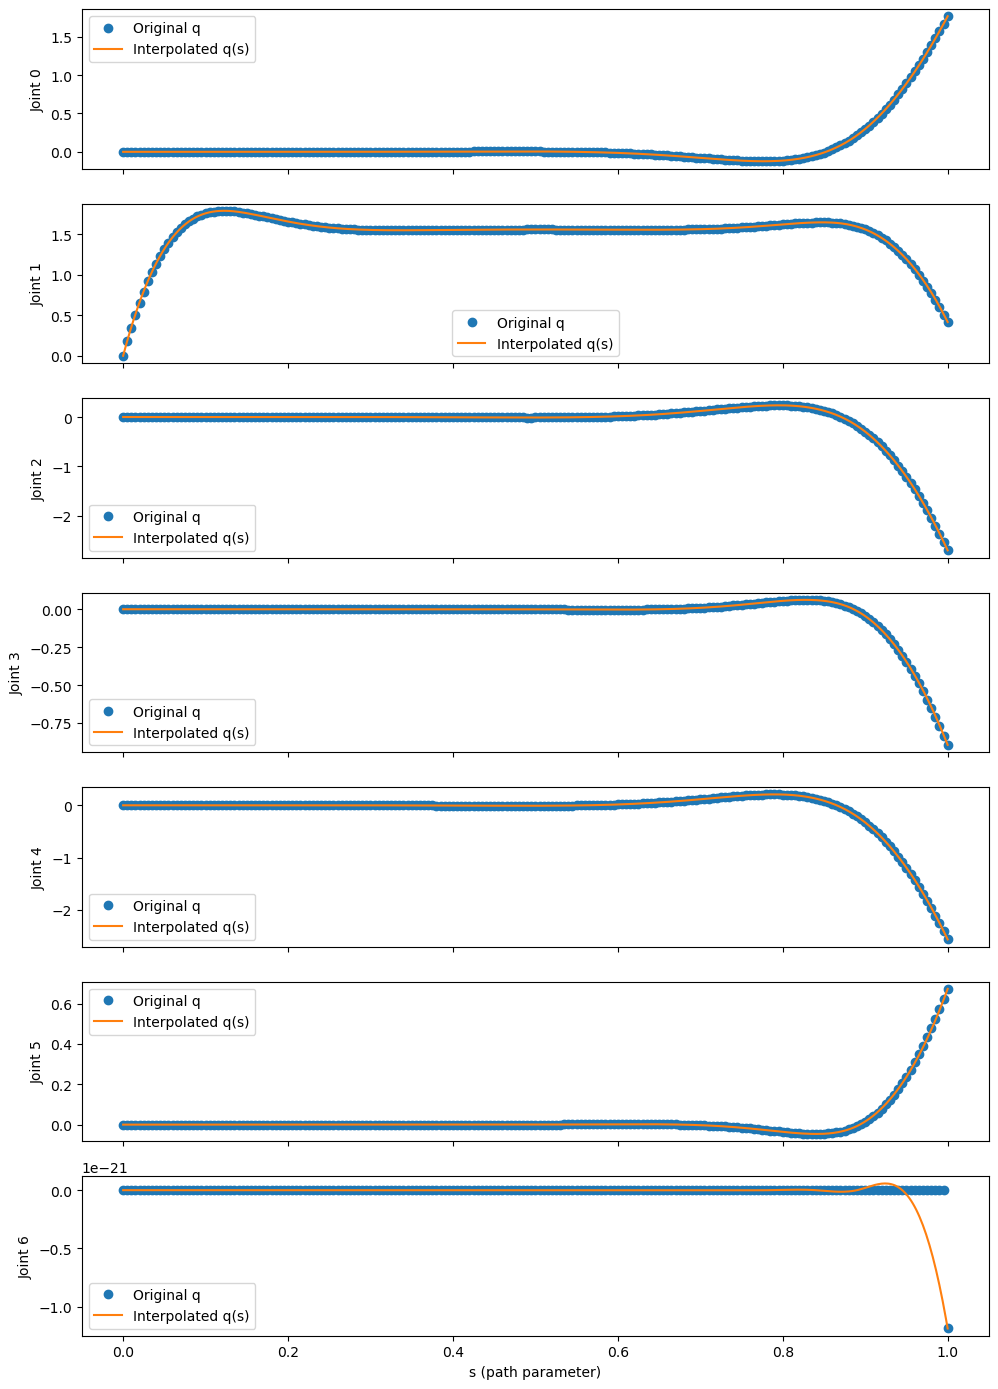

In [26]:
# Sous-échantillonnage : prendre seulement 20 points uniformément espacés
num_subsample = 20
indices_subsample = np.linspace(0, num_points - 1, num_subsample, dtype=int)

s_subsample = s_samples[indices_subsample]
q_subsample = q_traj_filtered[indices_subsample, :]

# Construire l’interpolateur spline avec moins de points
path_interpolator = ta.SplineInterpolator(s_subsample, q_subsample)

# Réévaluer densément pour visualisation
s_dense = np.linspace(0, 1, 500)
q_interp_dense = np.array([path_interpolator.eval(s) for s in s_dense])

# Affichage
fig, axs = plt.subplots(filtered_dof, 1, figsize=(10, 2 * filtered_dof), sharex=True)
for i in range(filtered_dof):
    axs[i].plot(s_samples, q_traj_filtered[:, i], 'o', label='Original q')
    axs[i].plot(s_dense, q_interp_dense[:, i], '-', label='Interpolated q(s)')
    axs[i].set_ylabel(f'Joint {i}')
    axs[i].legend()
axs[-1].set_xlabel('s (path parameter)')
plt.tight_layout()
plt.show()


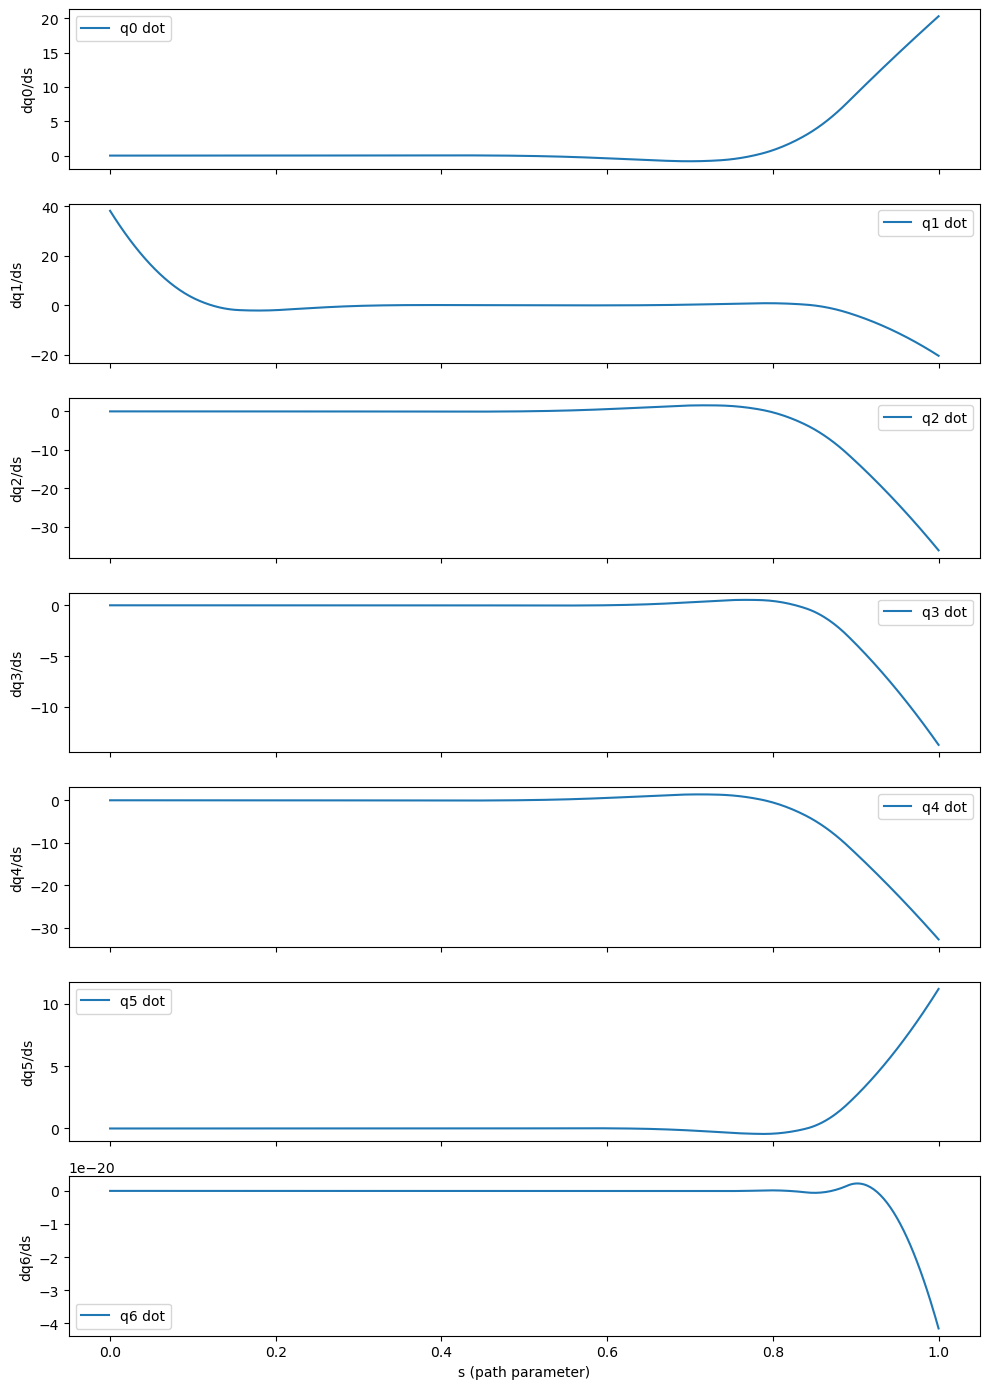

In [27]:
qdot_interp_dense = np.array([path_interpolator.evald(s) for s in s_dense])

fig, axs = plt.subplots(filtered_dof, 1, figsize=(10, 2 * filtered_dof), sharex=True)
for i in range(filtered_dof):
    axs[i].plot(s_dense, qdot_interp_dense[:, i], '-', label=f'q{i} dot')
    axs[i].set_ylabel(f'dq{i}/ds')
    axs[i].legend()
axs[-1].set_xlabel('s (path parameter)')
plt.tight_layout()
plt.show()


In [28]:
# Extract only active joint limits
vlim_active = model.velocityLimit[active_q_indices]
elim_active = model.effortLimit[active_q_indices]

print("=== Active Joint Limits ===")
for i, idx_q in enumerate(active_q_indices):
    joint_id = active_joint_ids[i]
    joint_name = model.names[joint_id]
    print(f"Joint {joint_name}: velocity ±{vlim_active[i]:.3f} rad/s, effort ±{elim_active[i]:.1f} Nm")


=== Active Joint Limits ===
Joint R_SHOULDER_P: velocity ±0.500 rad/s, effort ±176.0 Nm
Joint R_SHOULDER_R: velocity ±0.500 rad/s, effort ±176.0 Nm
Joint R_SHOULDER_Y: velocity ±0.500 rad/s, effort ±100.0 Nm
Joint R_ELBOW_P: velocity ±0.500 rad/s, effort ±100.0 Nm
Joint R_ELBOW_Y: velocity ±0.500 rad/s, effort ±100.0 Nm
Joint R_WRIST_R: velocity ±0.500 rad/s, effort ±40.0 Nm
Joint R_WRIST_Y: velocity ±0.500 rad/s, effort ±40.0 Nm


In [54]:
# Fonction inverse dynamique
def inv_dyn(q, qd, qdd):
    q_full = q0.copy()
    qd_full = np.zeros(model.nv)
    qdd_full = np.zeros(model.nv)
    
    q_full[active_q_indices] = q
    qd_full[active_q_indices] = qd
    qdd_full[active_q_indices] = qdd
    
    tau = pin.rnea(model, data, q_full, qd_full, qdd_full)
    return tau[active_q_indices]

# Définir tau_lim (min, max)
tau_lim = np.vstack([-elim_active, elim_active]).T  # shape (n_active, 2)

# Coefficients de friction sèche (on les met à zéro si non modélisés)
fs_coef = np.zeros(len(active_q_indices))

# Créer la contrainte
torque_constraint = constraint.JointTorqueConstraint(
    inv_dyn,
    tau_lim,
    fs_coef
)

# Construire le chemin toppra
path = ta.SplineInterpolator(s_samples, q_traj_filtered)

# Définir les autres contraintes
vel_constraint = constraint.JointVelocityConstraint(vlim_active)
acc_constraint = constraint.JointAccelerationConstraint(amax_active)

# Time-parameterization avec contraintes
instance = algo.TOPPRA([vel_constraint, acc_constraint, torque_constraint], path, solver_wrapper='seidel')
jnt_traj = instance.compute_trajectory(0, 0)


[INFO] amax per joint: [  5021.95005338   2673.83263604   9901.13438834  12079.64537619
 165123.5867485    1787.81638879  59010.95950065]


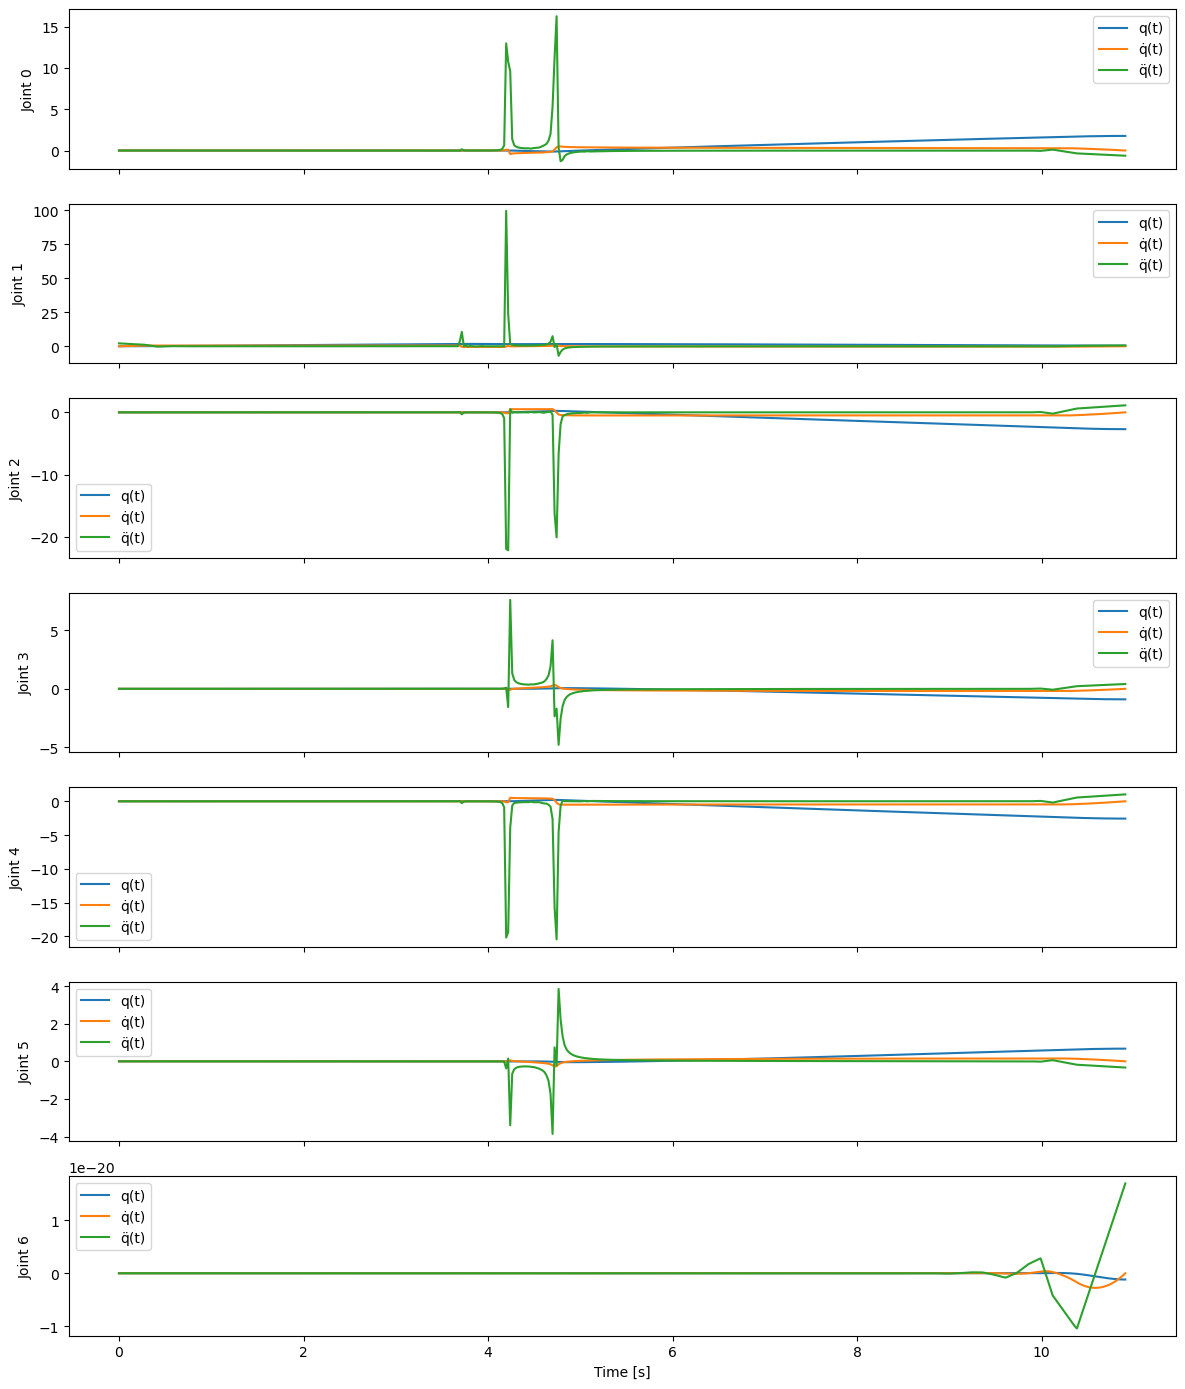

In [55]:
import toppra as ta
import toppra.constraint as constraint
import toppra.algorithm as algo

# --- Extraire limites actives ---
vlim_active = model.velocityLimit[active_q_indices]
elim_active = model.effortLimit[active_q_indices]

# Approximation des inerties (diagonale) pour chaque DOF
I_active = np.array([model.inertias[joint_id].inertia[0, 0] for joint_id in active_joint_ids])
amax_active = elim_active / (I_active * 3)  # rad/s²

print("[INFO] amax per joint:", amax_active)

# --- Fonction inverse dynamique ---
def inv_dyn(q, qd, qdd):
    q_full = q0.copy()
    qd_full = np.zeros(model.nv)
    qdd_full = np.zeros(model.nv)
    
    q_full[active_q_indices] = q
    qd_full[active_q_indices] = qd
    qdd_full[active_q_indices] = qdd
    
    tau = pin.rnea(model, data, q_full, qd_full, qdd_full)
    return tau[active_q_indices]

# --- Définir tau_lim et fs_coef ---
tau_lim = np.vstack([-elim_active, elim_active]).T  # shape (n_active, 2)
fs_coef = np.zeros(len(active_q_indices))

# --- Construire le chemin toppra ---
path = ta.SplineInterpolator(s_samples, q_traj_filtered)

# --- Définir les contraintes ---
vel_constraint = constraint.JointVelocityConstraint(vlim_active)
acc_constraint = constraint.JointAccelerationConstraint(amax_active)
torque_constraint = constraint.JointTorqueConstraint(inv_dyn, tau_lim, fs_coef)

# --- Time-parameterization ---
instance = algo.TOPPRA(
    [vel_constraint, acc_constraint, torque_constraint],
    path,
    solver_wrapper='seidel'
)
jnt_traj = instance.compute_trajectory(0, 0)  # start/end velocities zero

# --- Rééchantillonner en temps réel ---
duration = jnt_traj.duration
time_samples = np.linspace(0, duration, 500)

q_t = jnt_traj.eval(time_samples)
qd_t = jnt_traj.evald(time_samples)
qdd_t = jnt_traj.evaldd(time_samples)

# --- Affichage ---
fig, axs = plt.subplots(len(active_q_indices), 1, figsize=(12, 2 * len(active_q_indices)), sharex=True)
for i in range(len(active_q_indices)):
    axs[i].plot(time_samples, q_t[:, i], label='q(t)')
    axs[i].plot(time_samples, qd_t[:, i], label='q̇(t)')
    axs[i].plot(time_samples, qdd_t[:, i], label='q̈(t)')
    axs[i].set_ylabel(f'Joint {i}')
    axs[i].legend()
axs[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()


In [56]:
duration = jnt_traj.duration
print(f"Total duration: {duration:.3f} s")


Total duration: 10.906 s


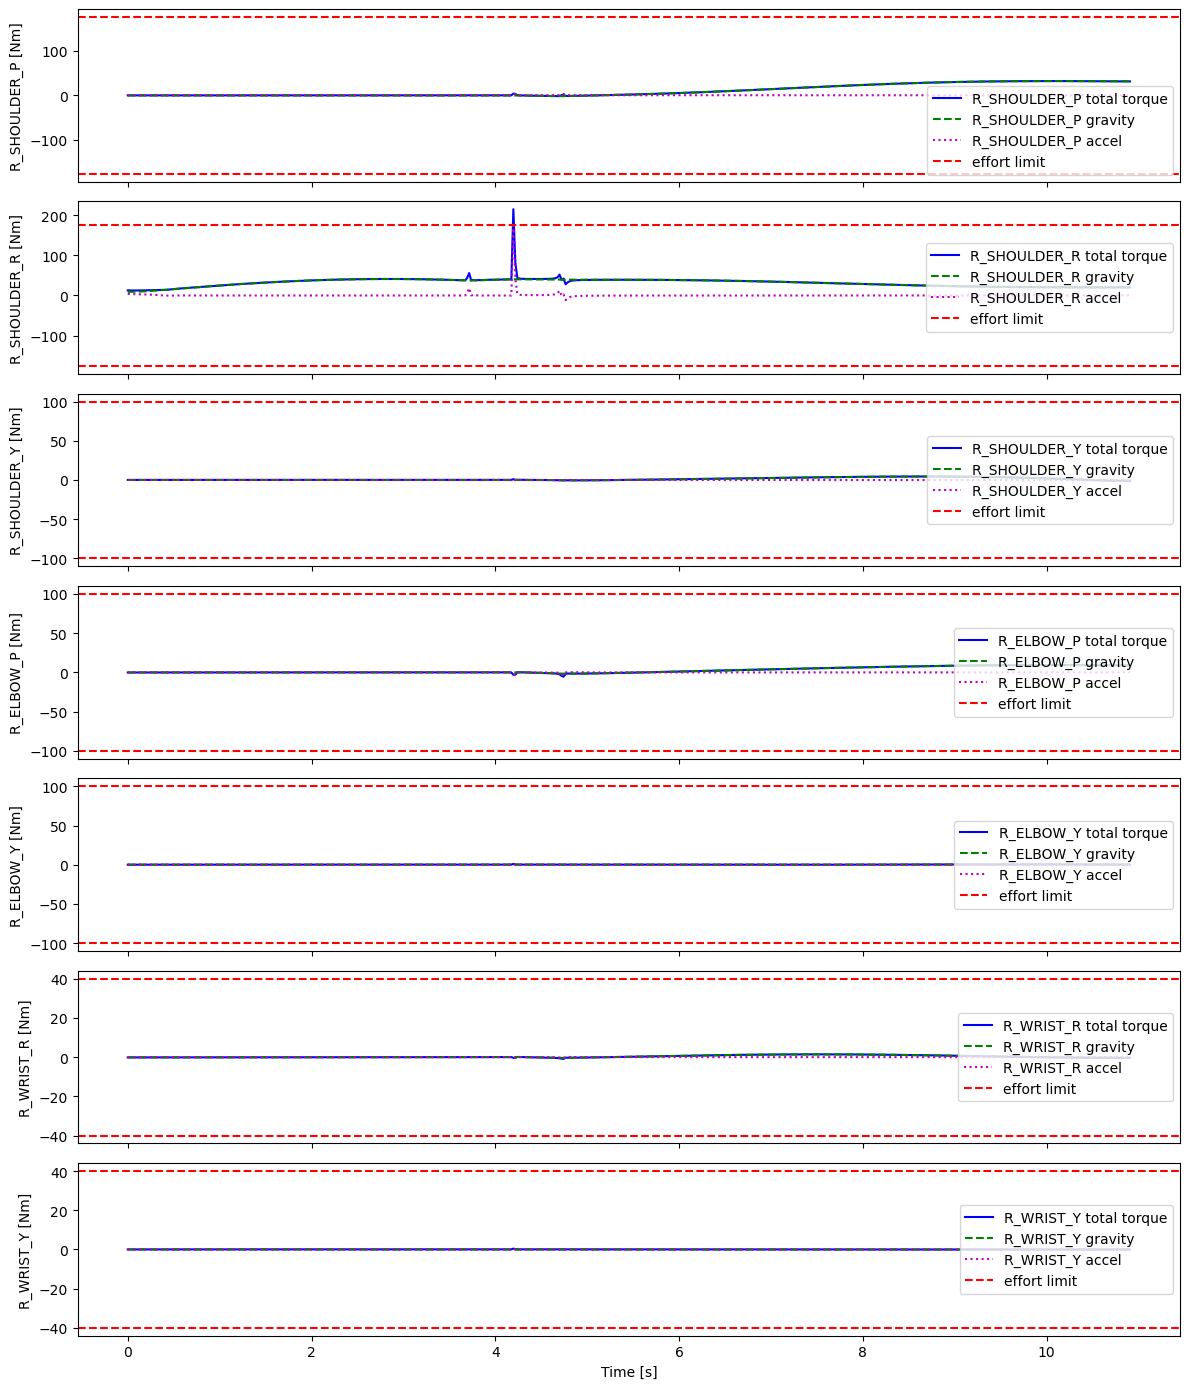

In [57]:
data = model.createData()
taus_total = []
taus_gravity = []
taus_accel = []

for i in range(len(time_samples)):
    q_full = q0.copy()
    qd_full = np.zeros(model.nv)
    qdd_full = np.zeros(model.nv)

    q_full[active_q_indices] = q_t[i]
    qd_full[active_q_indices] = qd_t[i]
    qdd_full[active_q_indices] = qdd_t[i]

    tau_grav = pin.computeGeneralizedGravity(model, data, q_full)
    tau_total = pin.rnea(model, data, q_full, qd_full, qdd_full)
    tau_accel = tau_total - tau_grav

    taus_total.append(tau_total[active_q_indices])
    taus_gravity.append(tau_grav[active_q_indices])
    taus_accel.append(tau_accel[active_q_indices])

taus_total = np.array(taus_total)
taus_gravity = np.array(taus_gravity)
taus_accel = np.array(taus_accel)

# --- Plot total torques and split components ---
fig, axs = plt.subplots(len(active_q_indices), 1, figsize=(12, 2 * len(active_q_indices)), sharex=True)
for i in range(len(active_q_indices)):
    joint_name = model.names[active_joint_ids[i]]
    axs[i].plot(time_samples, taus_total[:, i], label=f'{joint_name} total torque', color='b')
    axs[i].plot(time_samples, taus_gravity[:, i], label=f'{joint_name} gravity', color='g', linestyle='--')
    axs[i].plot(time_samples, taus_accel[:, i], label=f'{joint_name} accel', color='m', linestyle=':')
    axs[i].axhline(elim_active[i], color='r', linestyle='--', label='effort limit')
    axs[i].axhline(-elim_active[i], color='r', linestyle='--')
    axs[i].set_ylabel(f'{joint_name} [Nm]')
    axs[i].legend()
axs[-1].set_xlabel('Time [s]')
plt.tight_layout()
plt.show()


In [58]:
q_test = q0.copy()
q_test[active_q_indices[0]] += 0.5  # petit offset épaule
tau_grav = pin.computeGeneralizedGravity(model, data, q_test)
print("Tau grav (offset pose):", tau_grav[active_q_indices])


Tau grav (offset pose): [ 1.53498867e+01  1.04726435e+01  6.60151896e-02 -5.07475483e+00
  2.94997380e-02 -7.07625298e-01  1.48284970e-02]
